# Simple harmonic oscillator

Copyright (C) 2022 Richard Hacker

License: CC BY+SA

Source on [GitLab](https://gitlab.com/lerichi/applied-process-control-and-simulation/-/blob/main/Simple%20harmonic%20oscillator.ipynb)

In this article we will explore equations and algorithms required to synthesize a simple harmonic quadrature oscillator that operates at any desired frequency and amplitude.

In [1]:
# First load some required libraries

import numpy as np
from matplotlib import pyplot as plt
from contextlib import nullcontext
from lib.integrate import ode45

plt.rcParams['figure.figsize'] = [15, 7]

def amplitude(y):
    """Return the amplitude of a n-by-2 matrix"""
    return np.sqrt(np.sum(y*y, axis=1))


## Introduction

Often in control engineering and signal processing we would like to synthesize a sine/cosine wave source of arbitrary frequency and amplitude, both of which may change over time.


The most naive solution is to simply evaluate:
```python
t = 0.

while True:
    t = t + delta_T
    c,s = A0*cos(omega*t), A0*sin(omega*t)
```

Don't even think abount changing $\omega$ when $t \ne 0$, since you will get discontinuities in phase and subsequently in the calculated values. Changing amplitude *A0* will also cause discontinuities in the values.

A somewhat less naive solution is to integrate the angle and take the sine and cosine thereof, keeping angle continuous while frequency is changed:
```python
angle = 0.

while True:
    angle = angle + omega*delta_T
    c,s = A0*cos(angle), A0*sin(angle)
```

but you have to be careful that the angle stays within the range, otherwise you get numerical inaccuracies:

In [2]:
angle = 2.*np.pi*1.e15
print(f'sin({angle}) = {np.sin(angle)} (expected 0.0)')
print(f'cos({angle}) = {np.cos(angle)} (expected 1.0)')


sin(6283185307179586.0) = -0.45904974201514076 (expected 0.0)
cos(6283185307179586.0) = 0.8884105663238324 (expected 1.0)


and some arguments cannot even be calculated:

In [3]:
np.cos(1.e500)

# The following error message is deliberate

<ipython-input-3-30b210074f23>:1: RuntimeWarning: invalid value encountered in cos
  np.cos(1.e500)


nan

The author of this article has actually experienced the above effect in production software, only to read up in the documentation that this is a known issue. In fact, it was exactly this failure mode that led to the search for a sine wave source that could be operated forever.

If you are really careful, you would keep the phase within $\pm2\pi$:
```python
angle = 0.

while True:
    angle = angle + omega*delta_T
    
    if angle > 2*pi:
        angle -= 2*pi
        
    if angle < -2*pi:
        angle += 2*pi
        
    c,s = A0*cos(angle), A0*sin(angle)        
```

This would work, but the *if*-statements smell badly and the problem of adjusting amplitude without causing output discontinuities remains unresolved.

Lastly, the sine and cosine functions are computationally expensive, although it is difficult to show this in python as machines are nowadays really fast and operations are sometimes implemented directly in hardware:

In [4]:
with nullcontext():
    angle = np.arange(1e6)
    %timeit np.cos(angle)

18.4 ms ± 1.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


These problems are solved when the next state is calculated based on the previous state as will be shown next.

We will be having a look at both a continuous and discrete time quadrature oscillators.

## Continuous simple harmonic oscillator as a differential equation

Consider the following vector as a function of time:

$$
\mathbf{x} = \begin{bmatrix} A_0\,\cos{\omega\,t} \\ A_0\,\sin{\omega\,t} \end{bmatrix}
$$

where the amplitude $A_0$ and angular frequency $\omega$ are parameters and considered to be (semi-)constant over time.

Differentiating this with respect to time gives:

$$
\mathbf{\dot x} = \begin{bmatrix} -A_0\,\omega\,\sin{\omega\,t} \\ A_0\,\omega\,\cos{\omega\,t} \end{bmatrix}
$$

Notice that the derivatives can be expressed in terms of the states themselves, so the above equation can be rewritten as

$$
\mathbf{\dot x}= \begin{bmatrix} 0 & -\omega \\ \omega & 0 \end{bmatrix}\,\mathbf{x}
$$

which is a linear time invariant ordinary differential equation expressed in state-space form. The premultipying matrix is called the state transition matrix.

Expressing state evolution in this form is quite common for simulation and synthesis. Knowing an initial state, the equation is integrated numerically to obtain the state evolution over time. This is exactly what we require to synthesize an sine/cosine signal.

Without further ado, let's give this a try

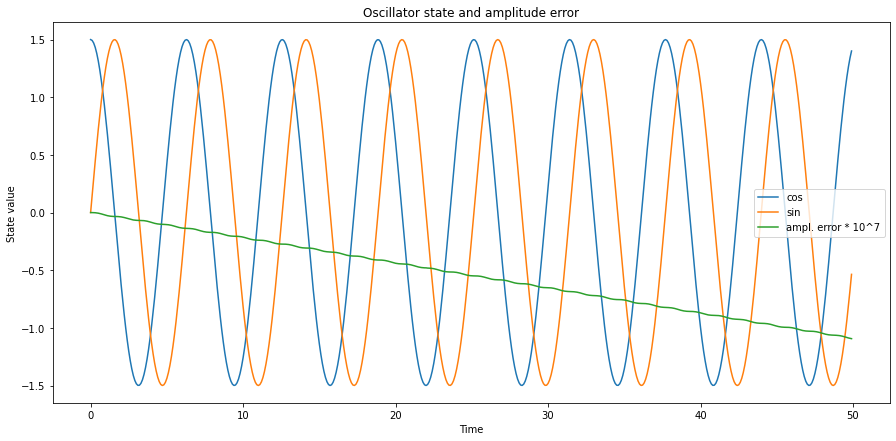

In [5]:
def osc_derivative(t, x, w):
    return np.array([-w, w])*np.flip(x)

# Oscillator with frequency 1 rad/s, with initial value (1.5, 0).
with ode45(osc_derivative, (1.5, 0)) as osc:
    T = np.arange(50., step=.1)
    omega = 1.
    
    y = np.vstack([osc.next(t, omega) for t in T])
    
    amplitude_error = amplitude(y) - 1.5
    
    plt.plot(T, y)
    plt.plot(T, amplitude_error * 1.e7)
    plt.title('Oscillator state and amplitude error')
    plt.ylabel('State value')
    plt.xlabel('Time')
    plt.legend(('cos','sin','ampl. error * 10^7'))


While this oscillator seems to be working just fine, the amplitude error shows that it is drifting continuously in one direction. This is not surprising, since numerical integration is not perfect and there is no element in the differential equation that "takes care of" amplitude.

So let's add a correcting factor δ to the differential equation to compensate for amplitude errors. The diagonal in the state transition matrix, zeros at the moment, lends itself quite nicely for this task as it biases the derivative proportionally to the current state.

$$
\mathbf{\dot x} = \begin{bmatrix} \delta & -\omega \\ \omega & \delta \end{bmatrix}\,\mathbf{x}
$$

The following non-linear function δ as a function of normalized amplitude $A_n$ is proposed:

$$
\delta(A_n) = \dfrac{1}{\Delta T}\dfrac{1 - A_n^2}{1 + A_n^2} \qquad A_n^2 = \left( \dfrac{|\mathbf x|}{A_0} \right)^2 = \dfrac{\mathbf x^\top\mathbf x}{A_0^2}
$$

Here, $\Delta T$ is the integration time step that influences how fast the amplitude converges to the setpoint.

Let's take a look at this function, pointing out that the *x*-axis is scaled logarithmically:

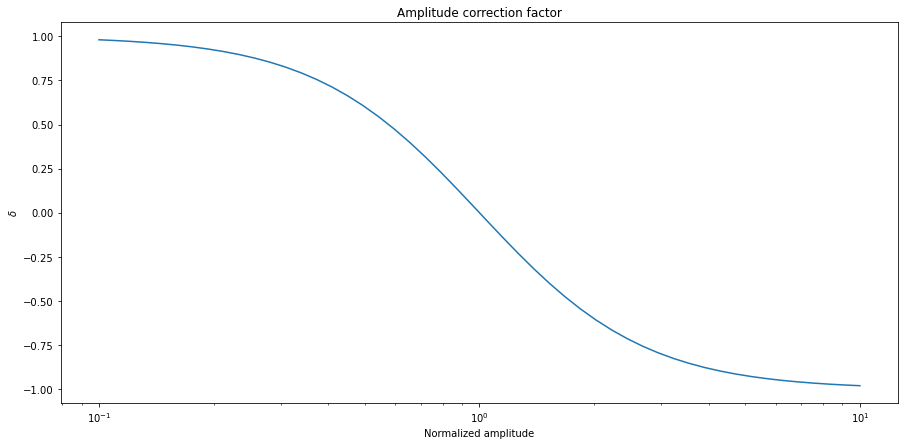

In [6]:
def delta(a):
    return (1. - a)/(1. + a)

with nullcontext():
    a = np.geomspace(0.1, 10)

    plt.semilogx(a, delta(a**2))
    plt.title('Amplitude correction factor')
    plt.ylabel('$\delta$')
    plt.xlabel('Normalized amplitude')
    

This function has several useful properties worthy to mention:
  * It is zero when *A* is unity, i.e. the amplitude is equal to its setpoint.
  * When amplitude is smaller than the setpoint ($A < 1$), $δ > 0$, letting amplitude increase over time. Similarly, when amplitude is larger than the setpoint ($A > 1$), $δ < 0$ so amplitude will decrease over time.
  * It saturates asymptotically to ±1, meaning that its effect in the transition matrix is always smaller than the off-diagonal elements that govern frequency, no matter what the amplitude setpoint is.
  * It is logarithmically symmetric about unity ($\delta(A^{-1}) = -\delta(A)$). So a normalized amplitude of 0.1 (δ = 0.99/1.01 = 0.98) has the same effect as a normalized amplitude of 10 (δ = -99/101 = -0.98) except for the negation.
  * It is smooth.
  
The reason for squaring normalized amplitude is that it relieves us from having to take the square root when determining oscillator amplitude.

Note that this is just an example for δ that works fairly well, but you may come up with your own version that works in your particular case better.

So let's see how this non-linear amplitude feedback control works:

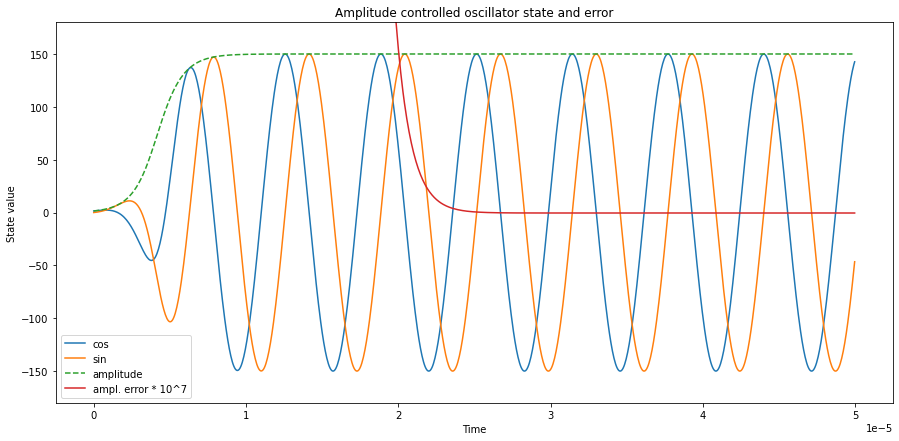

In [7]:
def derivative_with_amplitude(t, x, w, A, dT):
    
    normalized_amplitude = x@x / A / A
    
    d = delta(normalized_amplitude) / dT

    return np.array([[d, -w],
                     [w,  d]]) @ x


# Oscillator with frequency 1 rad/s, with initial value (1.5, 0),
# amplitude to be regulated to 10 times initial amplitude

with ode45(derivative_with_amplitude, (1.5, 0)) as osc:
    omega = 1.e6
    T = np.arange(50./omega, step=.05/omega)
    A = 100*osc.state[0]
    
    # Do the integration
    y = np.vstack([osc.next(t, omega, A, 1/omega) for t in T])
    
    amplitude_error = A - amplitude(y)
    
    plt.plot(T, y)
    plt.plot(T, amplitude(y), '--')
    plt.plot(T, amplitude_error * 1.e7)
    plt.title('Amplitude controlled oscillator state and error')
    plt.ylabel('State value')
    plt.xlabel('Time')
    plt.ylim(np.asarray((-1,1))*1.2*A)
    plt.legend(('cos','sin','amplitude', 'ampl. error * 10^7'))


This impressively shows how well amplitude feedback works, smoothly increasing amplitude to the setpoint.

The same deficit applies to phase error, since nothing "takes care of" phase in the differential equation.However, it is not the aim of this oscillator to be "in phase" forever.  For that purpose a phase locked loop (PLL) is required in addition to amplitude feedback. This oscillator should just be able to oscillate forever without obvious amplitude drift.

## Discrete simple harmonc oscillator as a difference equation

In this section we will be exploring a harmonic oscillator in the sampled data space.

Consider the following discrete state vector at sample _n_:

$$
\mathbf x_n = \begin{bmatrix} A_0\,\cos{n\,\omega_n} \\ A_0\,\sin{n\,\omega_n} \end{bmatrix}
\qquad n \in \mathbb{N}, \quad \omega_n \in [-\pi, \pi]
$$

The next time step in the sequence is

$$
\mathbf x_{n+1} = \begin{bmatrix} A_0\,\cos{(n+1)\,\omega_n} \\ A_0\,\sin{(n+1)\,\omega_n} \end{bmatrix}
$$

Expanding the trignometric identity for sum of angles gives

$$
\mathbf x_{n+1} = A_0\,\begin{bmatrix}
    \cos{n\,\omega_n}\,\cos\omega_n - \sin{n\,\omega_n}\,\sin\omega_n \\
    \sin{n\,\omega_n}\,\cos\omega_n + \cos{n\,\omega_n}\,\sin\omega_n \\
\end{bmatrix}
$$

We recognize that the next time step can be expressed in terms of the previous state, resulting in the discrete difference equation for a simple harmonic oscillator:

$$
\mathbf x_{n+1}
= \begin{bmatrix} \cos\omega_n & -\sin\omega_n \\ \sin\omega_n & \cos\omega_n \end{bmatrix}\,\mathbf x_n
$$

Notice that the discrete state transition matrix is simply the 2-D rotation matrix of angle $\omega_n$.

Similar to the continuous time case, state amplitude does not appear in the above equation. This lets us rightly doubt that the amplitude stays constant as numerical inaccuracies are not compensated for. In the same fashion an amplitude correction factor δ is introduced:

$$
\mathbf x_{n+1}
= \begin{bmatrix} \sqrt{1 - s_\omega^2} + \delta\,s_\omega & -s_\omega \\ s_\omega & \sqrt{1 - s_\omega^2} + \delta\,s_\omega \end{bmatrix}\,\mathbf x_n
%+ \mathbf d,
%\qquad s_\omega = \sin \omega_n
$$

Here, $\delta$ is the same as in the continuous case.

Let's have a look at a discrete oscillator:

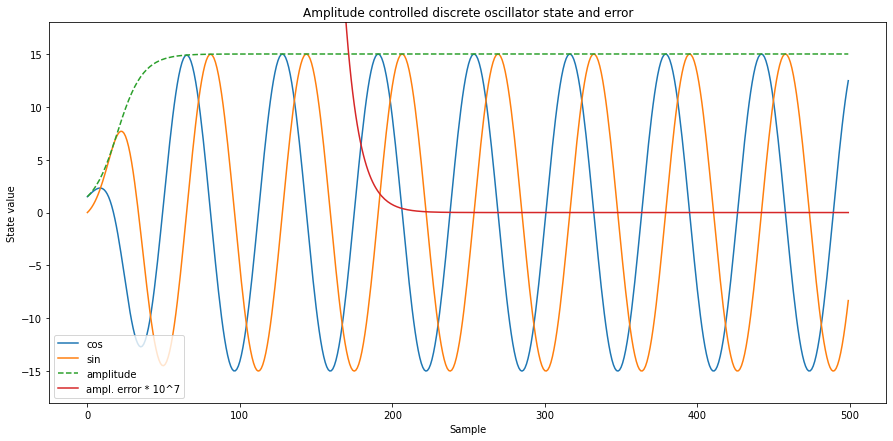

In [8]:
with nullcontext():
    w = 0.1
    k = 1.
    
    # Empty output vector, to be filled in
    y = np.zeros((500,2))
    
    # State vector
    x = np.asarray((1.5, 0))
    
    A = 10*x[0]
    
    sw = np.sin(w)
    cw = np.sqrt(1. - sw*sw) # Compute cosine using trignometric identity
    
    for _y in y:
        _y[:] = x
        
        d = delta(x@x/A/A) * sw
        
        x = np.array(((cw + d, -sw), (sw, cw + d)))@x
        
    amplitude_error = A - amplitude(y)
    plt.plot(y)
    plt.plot(amplitude(y), '--')
    plt.plot(amplitude_error * 1.e7)
    plt.title('Amplitude controlled discrete oscillator state and error')
    plt.ylabel('State value')
    plt.xlabel('Sample')
    plt.ylim(np.asarray((-1,1))*1.2*A)
    plt.legend(('cos','sin','amplitude','ampl. error * 10^7'))


This is almost identical to the continuous case

## Conclusion

In this article we explored methods to synthesize a sine/cosine oscillator. Arguments were presented to show why traditional use of the sine and cosine functions of an angle is poor design at best, inaccurate or even fatal at worst, and smelly in between. The mathematics behind stable quadrature oscillators were explored and implemented.